In [1]:
import time
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
import sklearn 
import sklearn.preprocessing

In [2]:
# params
seed = 42

In [3]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data',
                 header = None, sep = ' ')

# based on the .doc data description
df.columns = ['cheq_acc', 'dur_t', 'cred_hist', 'purp', 'cred_amt', 'save_acc', 
              'empl_t', 'inst_to_income', 'pers_status', 'guarant_flg',
              'residence_t', 'prop', 'age', 'inst_plan', 'house', 'n_loans',
              'job', 'n_depend', 'tel_flg', 'foreign_flg', 'target']

df.head()

,cheq_acc,dur_t,cred_hist,purp,cred_amt,save_acc,empl_t,inst_to_income,pers_status,guarant_flg,...,prop,age,inst_plan,house,n_loans,job,n_depend,tel_flg,foreign_flg,target
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,2


In [4]:
X = df.loc[:, df.columns != 'target']
y = df.target - 1

In [5]:
#Подготовка
from lightgbm import LGBMClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score


def Gini(y, y_pred):
    res = roc_auc_score(y, y_pred) * 2 - 1
    return(res)

In [6]:
from modules.encoders import WoEEncoder_adj
from feature_engine.encoding import OneHotEncoder
OneHot_module = OneHotEncoder()
WoE_module = WoEEncoder_adj()

In [7]:
StScal_mdl = sklearn.preprocessing.StandardScaler()
MMScal_mdl = sklearn.preprocessing.MinMaxScaler(feature_range=(1, 2))
RobScal_mdl = sklearn.preprocessing.RobustScaler()

In [8]:
from feature_engine.outliers import Winsorizer
from feature_engine.transformation import LogTransformer
from feature_engine.transformation import PowerTransformer
from feature_engine.transformation import BoxCoxTransformer
from feature_engine.transformation import YeoJohnsonTransformer

WinsTrans_module = Winsorizer()
LogTrans_module  = LogTransformer(base = '10')
PwrTrans_module  = PowerTransformer(exp = 0.5)
BxCxTrans_module = BoxCoxTransformer()
YeoJTrans_module = YeoJohnsonTransformer()


In [9]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from imblearn.under_sampling import RandomUnderSampler

RUS_module    = RandomUnderSampler(random_state = seed)
ROS_module    = RandomOverSampler(random_state = seed)
SMOTE_module  = SMOTE(random_state = seed)
ADASYN_module = ADASYN(random_state = seed)

In [10]:
from feature_engine.selection  import SmartCorrelatedSelection
SmartSel_module = SmartCorrelatedSelection(
    # variables=X.columns.to_list(),
    method="pearson",                # можно взять свою функцию
    threshold=0.3,                   # порог корреляции
    selection_method="variance",     # из коррелирующих групп выбираем признак с наиб дисперсией
    estimator=None,                  # понадобится для selection_method="model_performance"        
    cv=5
)
from feature_engine.selection  import RecursiveFeatureAddition
RecFeatAdd_module = RecursiveFeatureAddition( # rather slow
    lgbm_mdl,
    threshold = 0.005
)

NameError: name 'lgbm_mdl' is not defined

In [11]:
# import umap
import umap.umap_ as umap

class DimensionReducer():
    """
    Ugly wrapper fir various dimension reduction classes. Needed for 2 reasons:
    1. Features are not replaced, new ones are just added to df
    2. PCA output: np.array, should be replaced with pd.DataFrame 
    
    Comment AM: 
    1. Could be united with TransformerAdj class below, 
    2. .super() could be used
    """
    def __init__(self, gen_class, affx='feat', **kwargs):
        self.reducer = gen_class(**kwargs)
        self.affx = affx
        # self.reducer.set_params()
        
    def fit(self, X, y):
        self.reducer.fit(X, y)
        return self
    
    def transform(self, X):
        # potentially 
        Z = self.reducer.transform(X)
        return Z
    
    def set_params(self, **kwargs):
        self.reducer.set_params(**kwargs)
        return self  


Isomap_module = DimensionReducer(
    gen_class = sklearn.manifold.Isomap,
    n_neighbors = 5, #количество соседей при вычислении KNN. Основной гиперпараметр, кстати (!!!)
    n_components = 15,  #сколько оставить компонент; по дефолту - 2
    path_method = "auto", #алгоритм, который вычисляет кратчайший путь. Варианты см. на странице функции. Этот подбирает сам.
    neighbors_algorithm = "auto", #алгоритм, который ищет соседей. Инстанс класса NearestNeighbours
    n_jobs = -1 #объект умеет быть многопоточным! -1 займет все ядра
)

PCA_module = DimensionReducer(
    gen_class = sklearn.decomposition.PCA,
    n_components = 2,    # сколько оставить компонентов; по дефолту - все
    whiten = False,      # отключаем whitening - декорреляцию фичей
    svd_solver = "full", # детали SVD преобразования, за подробностями см. доки
)

UMAP_module = DimensionReducer(
    gen_class = umap.UMAP,
    n_neighbors = 5,  # количество соседей при вычислении KNN. Основной гиперпараметр, кстати (!!!)
    n_components = 2, # сколько оставить компонентов; по дефолту - 2
    min_dist = 0.1    # минимальная дистанция, которую можно сохранять между точками в получающемся пространстве. 
    # Гиперпараметр. При увеличении начинает лучше улавливать общую структуру, но хуже - локальную
)

In [12]:
train = pd.concat([y, X], axis=1)
X_train_b = []
y_train_b = []
X_bag = []
y_bag = []
for i in range (100):
    a = (train.sample(n = 800,  replace=True, random_state = i))
    b = pd.concat([train, a, a]).drop_duplicates(keep=False)
    X_train_b.append(a.loc[:, a.columns != 'target'])
    y_train_b.append(a.target)
    X_bag.append(b.loc[:, b.columns != 'target'])
    y_bag.append(b.target)

In [55]:
from sklearn.neighbors import KNeighborsClassifier
from imblearn.pipeline import Pipeline as imbPipeline
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
from functools import partial
from sklearn.model_selection import cross_val_score, StratifiedKFold
seed = 42
lgbm_mdl = LGBMClassifier(
    num_leaves = 12,
    learning_rate = .1,
    reg_alpha = 0,
    reg_lambda = 9,
    n_estimators= 100,
    random_state = seed
)

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

LDA = LinearDiscriminantAnalysis()

mdl_pipe_impute = imbPipeline(
    [('encode', WoE_module), 
     #('StScal_mdl', RobScal_mdl),
     ('Win', YeoJTrans_module), 
     #('imb', ADASYN_module),
     ('model', LDA)]
)

search_space = {
        'model__solver': hp.choice('solver', ['svd', 'lsqr', 'eigen']),
        #'model__tol': hp.choice('tol', np.arange(0, 1, 0.0001, dtype=int))
                }




def objective(params, pipeline,  X_train, y_train):
    """
    Кросс-валидация с текущими гиперпараметрами

    :params: гиперпараметры
    :pipeline: модель
    :X_train: матрица признаков
    :y_train: вектор меток объектов
    :return: средняя точность на кросс-валидации
    """ 

    # задаём модели требуемые параметры    
    pipeline.set_params(**params)

    # задаём параметры кросс-валидации (стратифицированная 4-фолдовая с перемешиванием)
    skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=1)

    # проводим кросс-валидацию  
    score = cross_val_score(estimator=pipeline, X=X_train, y=y_train, 
                            cv=skf, n_jobs=-1)

    # возвращаем результаты, которые записываются в Trials()
    return   {'loss': -score.mean(), 'params': params, 'status': STATUS_OK}


trials = Trials()
best = fmin( 
          # функция для оптимизации  
            fn=partial(objective, pipeline=mdl_pipe_impute, X_train=X, y_train=y),
          # пространство поиска гиперпараметров  
            space=search_space,
          # алгоритм поиска
            algo=tpe.suggest,
          # число итераций 
          # (можно ещё указать и время поиска) 
            max_evals=40,
          # куда сохранять историю поиска
            trials=trials,
          # random state
            rstate=np.random.RandomState(1),
          # progressbar
            show_progressbar=True
        )
from hyperopt import space_eval
best_params = space_eval(search_space, best)
mdl_pipe_impute.set_params(**best_params)

from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import f1_score
import warnings
warnings.filterwarnings("ignore")
mdl_pipe_impute.fit(X, y)
c = Gini(y, mdl_pipe_impute.predict_proba(X)[:, 1])
c1 = balanced_accuracy_score(y, mdl_pipe_impute.predict(X))
c2 = f1_score(y, mdl_pipe_impute.predict(X))
gini = []
b_acc = []
f1 = []
for i in range(100):

    mdl_pipe_impute.fit(X_train_b[i], y_train_b[i])

    gini.append(0.632*Gini(y_bag[i], mdl_pipe_impute.predict_proba(X_bag[i])[:, 1]) + c*0.368)
    b_acc.append(0.632*balanced_accuracy_score(y_bag[i], mdl_pipe_impute.predict(X_bag[i])) + c1*0.368)
    f1.append(0.632*f1_score(y_bag[i], mdl_pipe_impute.predict(X_bag[i])) + c2*0.368)

100%|███████████████████████████████████████████████| 40/40 [00:10<00:00,  3.71trial/s, best loss: -0.7510000000000001]


In [56]:
results_lgbm = pd.DataFrame({"full" : gini})
results1_lgbm = pd.DataFrame({"full" : b_acc})
results2_lgbm = pd.DataFrame({"full" : f1})

In [57]:
from sklearn.neighbors import KNeighborsClassifier
from imblearn.pipeline import Pipeline as imbPipeline
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
from functools import partial
from sklearn.model_selection import cross_val_score, StratifiedKFold
seed = 42
lgbm_mdl = LGBMClassifier(
    num_leaves = 12,
    learning_rate = .1,
    reg_alpha = 0,
    reg_lambda = 9,
    n_estimators= 100,
    random_state = seed
)

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

LDA = LinearDiscriminantAnalysis()

mdl_pipe_impute = imbPipeline(
    [('encode', WoE_module), 
     #('StScal_mdl', RobScal_mdl),
     #('Win', YeoJTrans_module), 
     #('imb', ADASYN_module),
     ('model', LDA)]
)

search_space = {
        'model__solver': hp.choice('solver', ['svd', 'lsqr', 'eigen']),
        #'model__tol': hp.choice('tol', np.arange(0, 1, 0.0001, dtype=int))
                }




def objective(params, pipeline,  X_train, y_train):
    """
    Кросс-валидация с текущими гиперпараметрами

    :params: гиперпараметры
    :pipeline: модель
    :X_train: матрица признаков
    :y_train: вектор меток объектов
    :return: средняя точность на кросс-валидации
    """ 

    # задаём модели требуемые параметры    
    pipeline.set_params(**params)

    # задаём параметры кросс-валидации (стратифицированная 4-фолдовая с перемешиванием)
    skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=1)

    # проводим кросс-валидацию  
    score = cross_val_score(estimator=pipeline, X=X_train, y=y_train, 
                            cv=skf, n_jobs=-1)

    # возвращаем результаты, которые записываются в Trials()
    return   {'loss': -score.mean(), 'params': params, 'status': STATUS_OK}


trials = Trials()
best = fmin( 
          # функция для оптимизации  
            fn=partial(objective, pipeline=mdl_pipe_impute, X_train=X, y_train=y),
          # пространство поиска гиперпараметров  
            space=search_space,
          # алгоритм поиска
            algo=tpe.suggest,
          # число итераций 
          # (можно ещё указать и время поиска) 
            max_evals=40,
          # куда сохранять историю поиска
            trials=trials,
          # random state
            rstate=np.random.RandomState(1),
          # progressbar
            show_progressbar=True
        )
from hyperopt import space_eval
best_params = space_eval(search_space, best)
mdl_pipe_impute.set_params(**best_params)

from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import f1_score
import warnings
warnings.filterwarnings("ignore")
mdl_pipe_impute.fit(X, y)
c = Gini(y, mdl_pipe_impute.predict_proba(X)[:, 1])
c1 = balanced_accuracy_score(y, mdl_pipe_impute.predict(X))
c2 = f1_score(y, mdl_pipe_impute.predict(X))
gini = []
b_acc = []
f1 = []
for i in range(100):

    mdl_pipe_impute.fit(X_train_b[i], y_train_b[i])

    gini.append(0.632*Gini(y_bag[i], mdl_pipe_impute.predict_proba(X_bag[i])[:, 1]) + c*0.368)
    b_acc.append(0.632*balanced_accuracy_score(y_bag[i], mdl_pipe_impute.predict(X_bag[i])) + c1*0.368)
    f1.append(0.632*f1_score(y_bag[i], mdl_pipe_impute.predict(X_bag[i])) + c2*0.368)

100%|████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.29trial/s, best loss: -0.748]


In [58]:
results_lgbm['No transformation'] = gini
results1_lgbm['No transformation'] = b_acc
results2_lgbm['No transformation'] = f1

In [59]:
results_lgbm.mean()

full                 0.589804
No transformation    0.589767
dtype: float64

In [60]:
results1_lgbm.mean()

full                 0.676920
No transformation    0.680435
dtype: float64

In [61]:
results2_lgbm.mean()

full                 0.540654
No transformation    0.545530
dtype: float64

In [62]:
results_lgbm.std()

full                 0.020929
No transformation    0.020736
dtype: float64

In [63]:
results1_lgbm.std()

full                 0.012195
No transformation    0.013600
dtype: float64

In [64]:
results2_lgbm.std()

full                 0.019988
No transformation    0.022014
dtype: float64

In [65]:
from scipy import stats
stats.ttest_ind(results_lgbm['full'], results_lgbm['No transformation'], equal_var = False)

Ttest_indResult(statistic=0.012407141931838107, pvalue=0.9901132804071278)

In [66]:
stats.ttest_ind(results1_lgbm['full'], results1_lgbm['No transformation'], equal_var = False)

Ttest_indResult(statistic=-1.9245889185513227, pvalue=0.05573113561634933)

In [67]:
stats.ttest_ind(results2_lgbm['full'], results2_lgbm['No transformation'], equal_var = False)

Ttest_indResult(statistic=-1.6400040792880255, pvalue=0.1026067498666758)

[None, None, None, None]

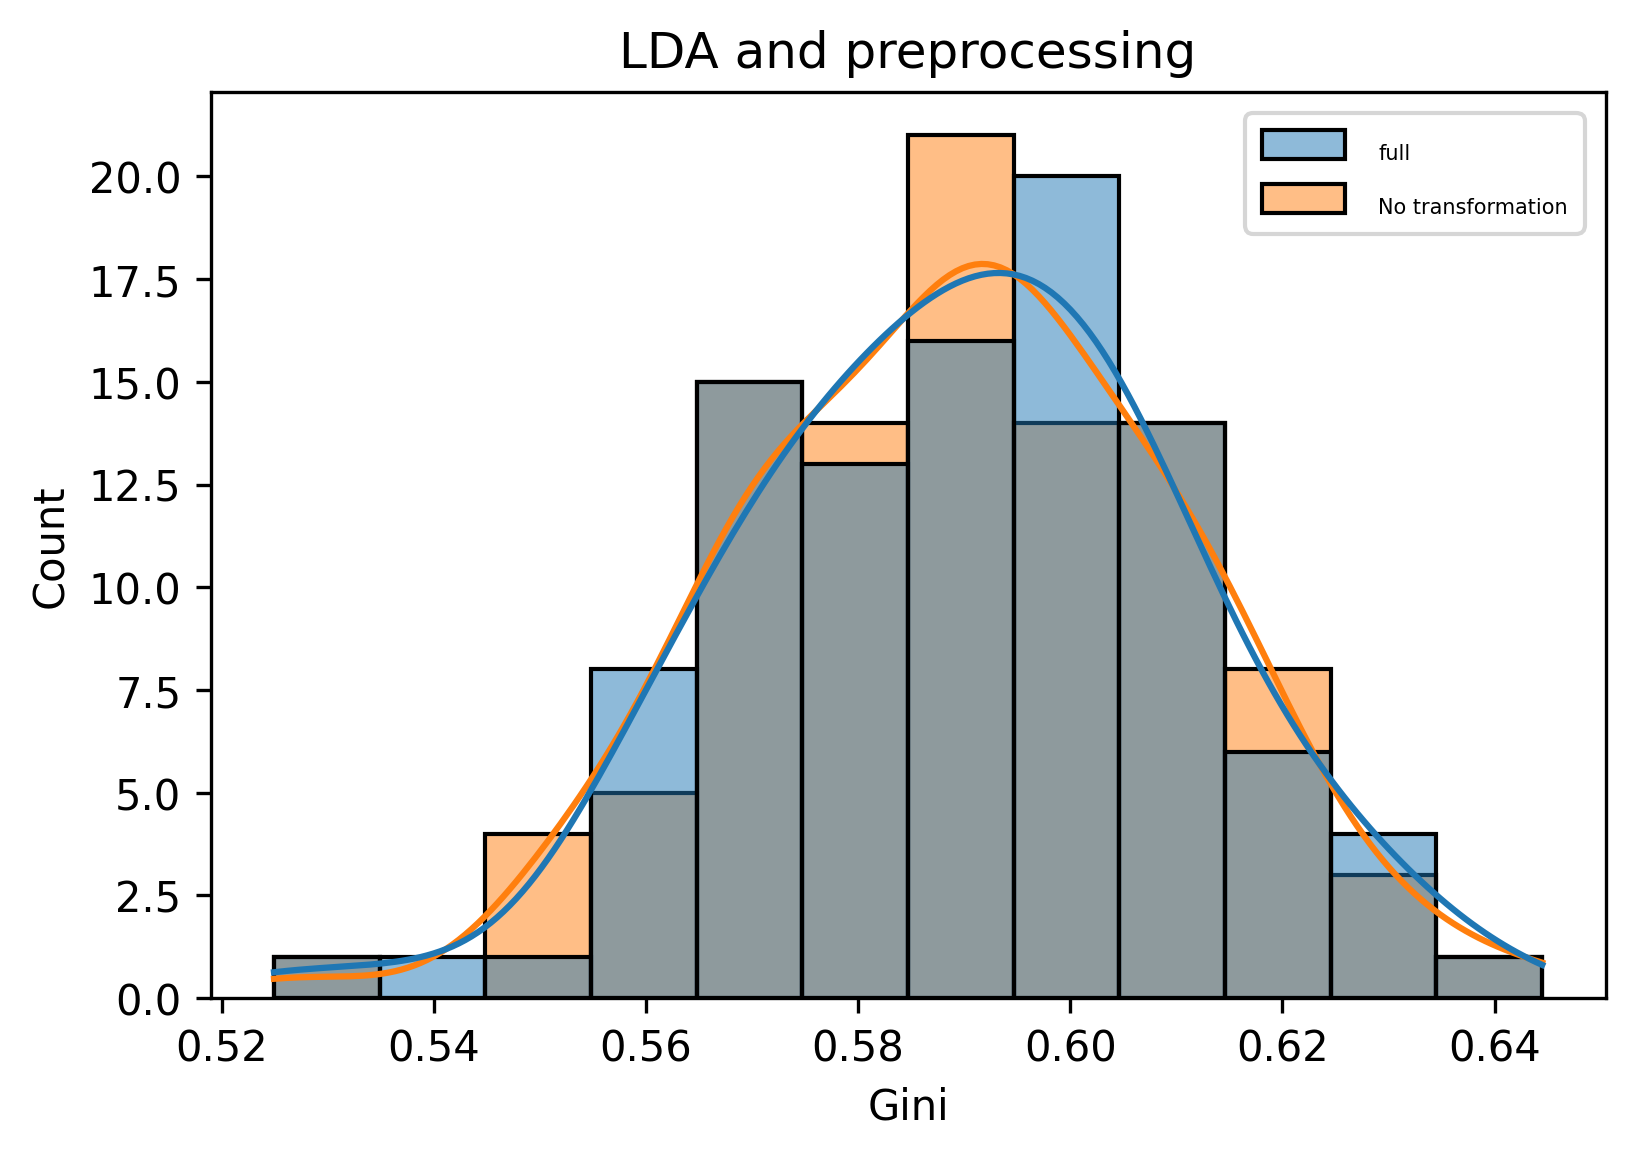

In [69]:
plt.rcParams['figure.dpi'] = 300
ax = sns.histplot(results_lgbm, kde=True, element = 'bars')
ax.set_xlabel("Gini", fontsize = 10)
ax.set(title='LDA and preprocessing')
plt.setp(ax.get_legend().get_texts(), fontsize='5')

[None, None, None, None]

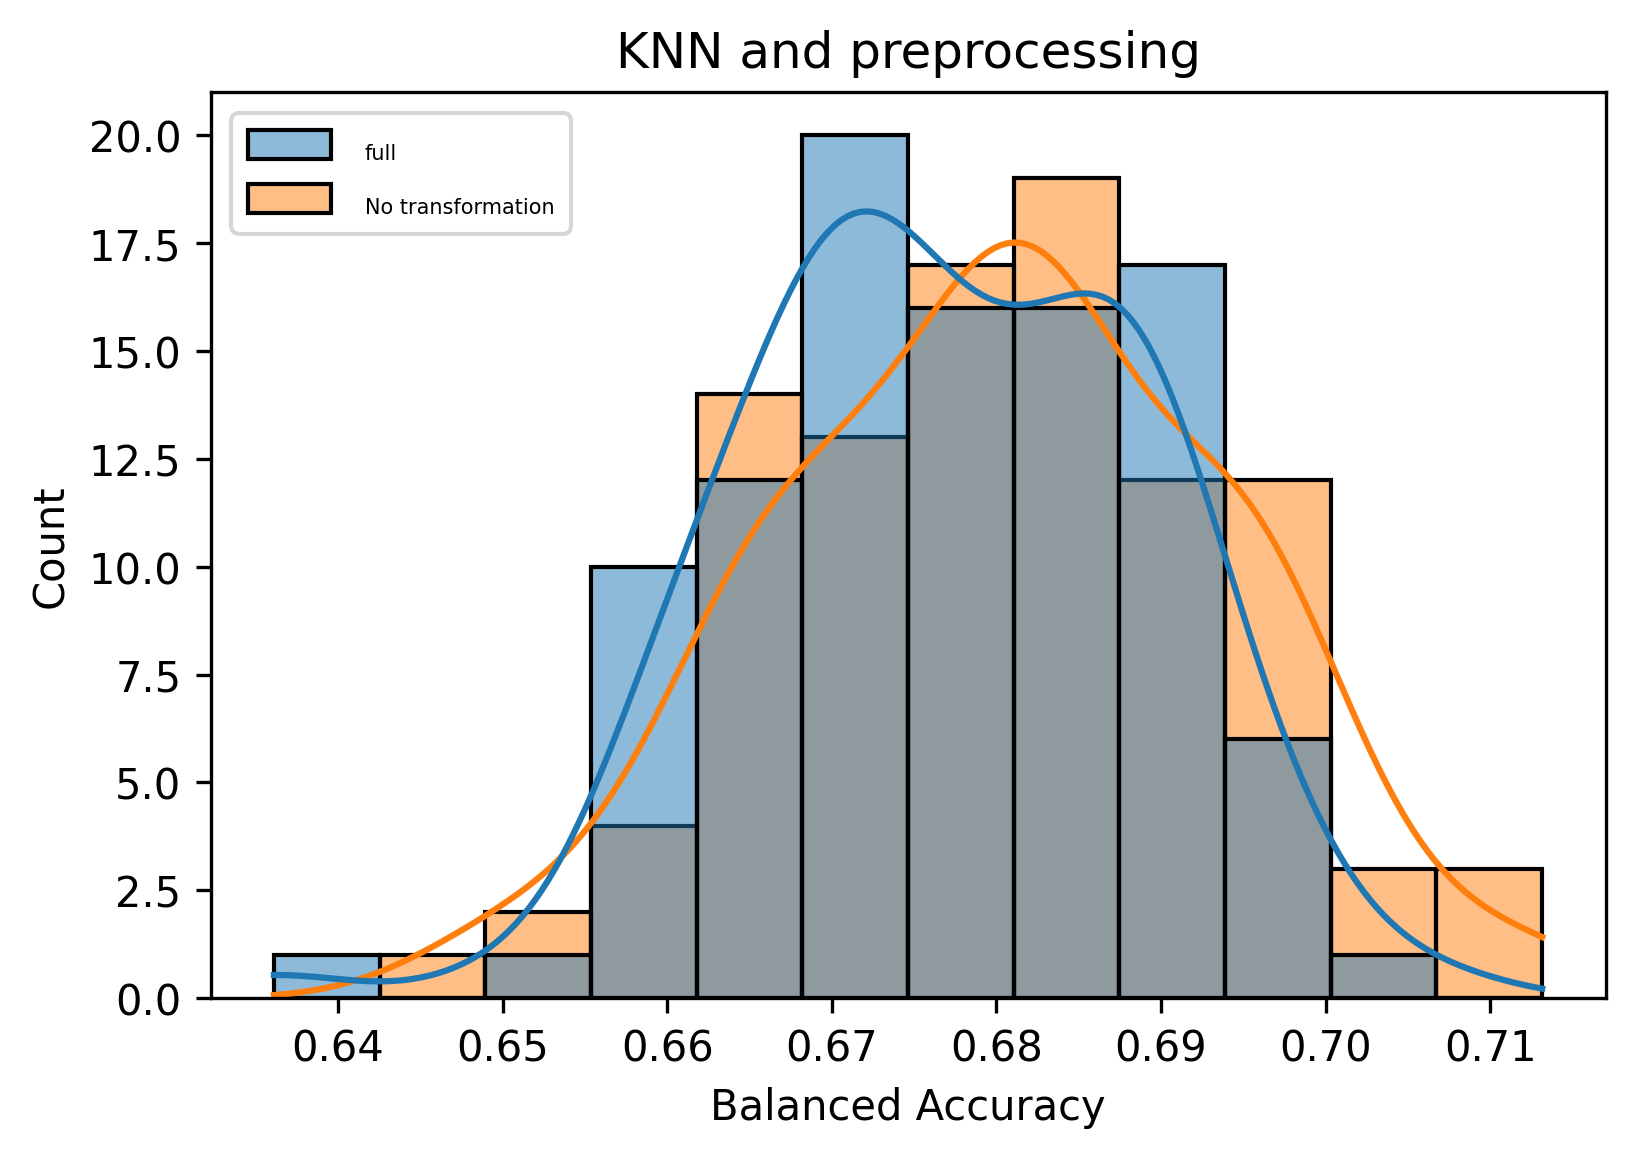

In [70]:
ax = sns.histplot(results1_lgbm, kde=True, element = 'bars')
ax.set_xlabel("Balanced Accuracy", fontsize = 10)
ax.set(title='KNN and preprocessing')
sns.move_legend(ax, "upper left")
plt.setp(ax.get_legend().get_texts(), fontsize='5')

[None, None, None, None]

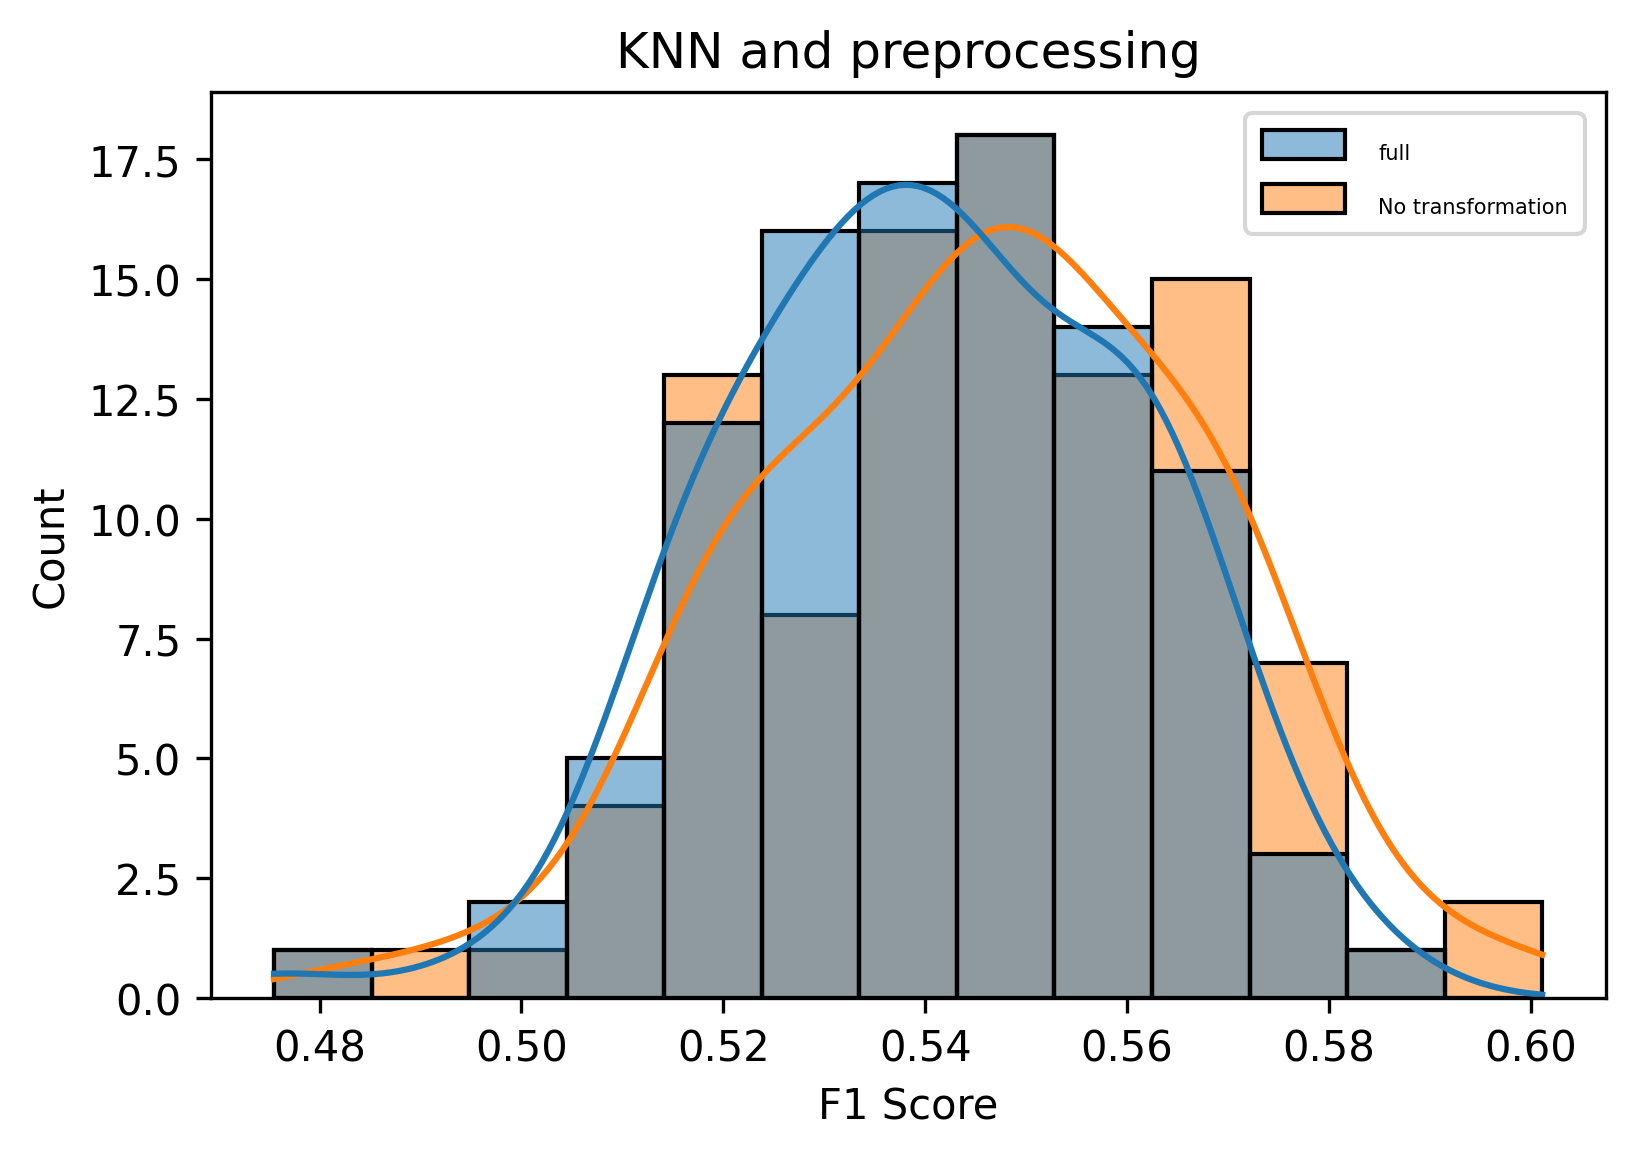

In [71]:
ax = sns.histplot(results2_lgbm, kde=True, element = 'bars')
ax.set_xlabel("F1 Score", fontsize = 10)
ax.set(title='KNN and preprocessing')
plt.setp(ax.get_legend().get_texts(), fontsize='5')